In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image  as mpimg
import tensorflow_datasets as tfds
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
train_data, validation_data, test_data = tfds.load('deep_weeds', split=['train[:80%]', 'train[81%:90%]', 'train[91%:]'], as_supervised=True)

TARGET_SIZE = (128, 128)
TARGET_SHAPE = (TARGET_SIZE[0], TARGET_SIZE[1], 3)

train_data = train_data.map(lambda x, y: (tf.image.resize(x, TARGET_SIZE), y))
validation_data = validation_data.map(lambda x, y: (tf.image.resize(x, TARGET_SIZE), y))
test_data = test_data.map(lambda x, y: (tf.image.resize(x, TARGET_SIZE), y))


#steps = 41
train_data = train_data.shuffle(1024) #.batch(150)
validation_data = validation_data.shuffle(1024) #.batch(25)


print("Number of training samples: %d" % tf.data.experimental.cardinality(train_data))
print("Number of validation samples: %d" % tf.data.experimental.cardinality(validation_data))
print("Number of test samples: %d" % tf.data.experimental.cardinality(test_data))

Number of training samples: 14007
Number of validation samples: 1576
Number of test samples: 1576


tf.Tensor(
[[[[0.35588235 0.37156862 0.3754902 ]
   [0.4137255  0.42941177 0.43333334]
   [0.30686274 0.32254902 0.32647058]
   ...
   [0.16666667 0.18235295 0.18627451]
   [0.1872549  0.20294118 0.20686275]
   [0.34019607 0.35588235 0.35980392]]

  [[0.5147059  0.53039217 0.53431374]
   [0.47254902 0.4882353  0.49215686]
   [0.33333334 0.34901962 0.3529412 ]
   ...
   [0.3127451  0.32843137 0.33235294]
   [0.15196079 0.16764706 0.17156863]
   [0.29411766 0.30980393 0.3137255 ]]

  [[0.53333336 0.54901963 0.5529412 ]
   [0.5764706  0.5921569  0.59607846]
   [0.4745098  0.49019608 0.49411765]
   ...
   [0.40882352 0.4245098  0.42058823]
   [0.16960785 0.18529412 0.18137255]
   [0.26568627 0.28137255 0.27745098]]

  ...

  [[0.5117647  0.527451   0.5392157 ]
   [0.68921566 0.70490193 0.7107843 ]
   [0.46372548 0.47941175 0.47549018]
   ...
   [0.38137254 0.38921568 0.37745097]
   [0.16666667 0.16666667 0.16666667]
   [0.5529412  0.5529412  0.56078434]]

  [[0.3754902  0.3882353  0.405882

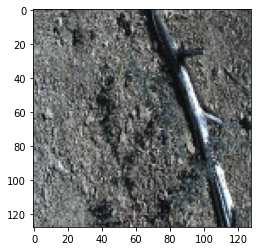

In [3]:
input = keras.Input(shape=TARGET_SHAPE)
normalizer = keras.layers.experimental.preprocessing.Normalization()
preprocess = normalizer(input)
normalizer.set_weights([np.array([0] * 3), np.array([255**2] * 3)])

image_batch, label_batch = next(iter(train_data))
test = normalizer(image_batch)
print(test)
print(label_batch)
plt.imshow(tf.reshape(test, (128, 128, 3)))

In [100]:
base_model = keras.applications.ResNet101V2(include_top=False, weights='imagenet', pooling='avg', input_shape=TARGET_SHAPE)
base_model.trainable = False
#print(base_model.summary())
#img = train_data.take(1)
#print(img)
#image_batch, label_batch = next(iter(train_data))
#print(image_batch)
#plt.imshow(image_batch / 255.0)
#feature_batch = base_model(image_batch)
#print(feature_batch.shape)

features = base_model(preprocess, training=False)
dense_layer = keras.layers.Dense(512,
                                     activation='relu',
                                     kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),
                                     bias_regularizer=keras.regularizers.l2(1e-4),
                                     activity_regularizer=keras.regularizers.l2(1e-5)
                                    )
dropout = keras.layers.Dropout(0.25)
classifier_head = keras.layers.Dense(9, 
                                     activation='softmax',
                                     
                                    )

outputs = classifier_head(dropout(dense_layer(features)))
#outputs = classifier_head(dense_layer(features))
print(outputs.shape)

model = keras.Model(input, outputs)

print(model.summary())

(None, 9)
Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
normalization (Normalization (None, 128, 128, 3)       7         
_________________________________________________________________
resnet101v2 (Functional)     (None, 2048)              42626560  
_________________________________________________________________
dense_14 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 9)                 4617      
Total params: 43,680,272
Trainable params: 1,053,705
Non-trainable params: 42,626,567
_______________________

In [101]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'],
)

#print(model.summary())
history = model.fit(train_data.batch(251)
, epochs=7
, validation_data=validation_data.batch(250)
, validation_steps=7
, steps_per_epoch=56
)

#model.save_weights("classifier_head_weights.tf")

Epoch 1/7
56/56 [==============================] - 32s 571ms/step - loss: 1.5810 - accuracy: 0.5806 - val_loss: 1.3344 - val_accuracy: 0.6199
Epoch 2/7
56/56 [==============================] - 30s 542ms/step - loss: 1.1795 - accuracy: 0.6765 - val_loss: 1.2368 - val_accuracy: 0.6516
Epoch 3/7
56/56 [==============================] - 30s 544ms/step - loss: 1.0237 - accuracy: 0.7243 - val_loss: 1.1828 - val_accuracy: 0.6599
Epoch 4/7
56/56 [==============================] - 30s 542ms/step - loss: 0.9100 - accuracy: 0.7563 - val_loss: 1.1798 - val_accuracy: 0.6739
Epoch 5/7
56/56 [==============================] - 30s 544ms/step - loss: 0.8417 - accuracy: 0.7803 - val_loss: 1.1521 - val_accuracy: 0.6789
Epoch 6/7
56/56 [==============================] - 31s 553ms/step - loss: 0.7644 - accuracy: 0.8112 - val_loss: 1.1624 - val_accuracy: 0.6821
Epoch 7/7
56/56 [==============================] - 31s 545ms/step - loss: 0.7140 - accuracy: 0.8275 - val_loss: 1.1721 - val_accuracy: 0.6764


<Figure size 432x288 with 0 Axes>

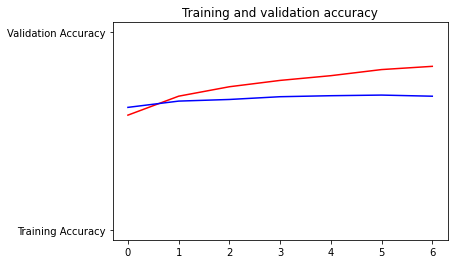

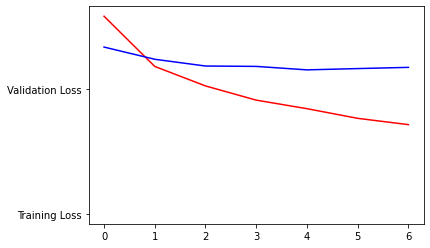

<Figure size 432x288 with 0 Axes>

In [108]:
%matplotlib inline
#print(history.history)

acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.figure()

In [103]:
loss, accuracy = model.evaluate(test_data.batch(100))
print(accuracy)

16/16 [==============================] - 2s 122ms/step - loss: 1.1808 - accuracy: 0.6796
0.6795685291290283


In [113]:
#start fine tuning
base_model.trainable = True

#res net 101 has a crazy number of layers.  Look at the model summary to figure out what to unfreeze  
FINE_TUNE_COUNT = 8
print(len(base_model.layers))
print(base_model.summary())

for layer in base_model.layers[:-1 * FINE_TUNE_COUNT]:
    layer.trainable = False
    

#note that Adam default is 0.001 
FINE_TUNING_LR = 0.00001
    
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=FINE_TUNING_LR),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'],
)

print(model.summary())


378
Model: "resnet101v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_9[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 66, 66, 64)   0           conv1_conv[0][0]                 
____________________________________________________________________________________

In [112]:
#want the model to start fine tuning from here every time
#model.load_weights("classifier_head_weights.tf")

original_epochs = 7
fine_tuning_epochs = 3

#print(model.summary())
history_fine = model.fit(train_data.batch(251)
, epochs = original_epochs + fine_tuning_epochs + 1
, validation_data=validation_data.batch(250)
, validation_steps=7
, steps_per_epoch=56
, initial_epoch=original_epochs + 1
)

Epoch 7/9
10/56 [====>.........................] - ETA: 22s - loss: 0.3744 - accuracy: 0.9538

KeyboardInterrupt: 

In [111]:
loss, accuracy = model.evaluate(test_data.batch(100))
print(accuracy)

16/16 [==============================] - 2s 122ms/step - loss: 1.2869 - accuracy: 0.6961
0.6960659623146057


[0.5806382298469543, 0.6765188574790955, 0.7242807149887085, 0.7563360929489136, 0.7802527546882629, 0.8111658692359924, 0.8275148272514343]


<Figure size 432x288 with 0 Axes>

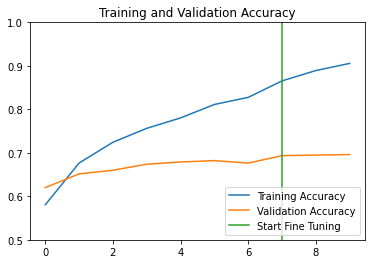

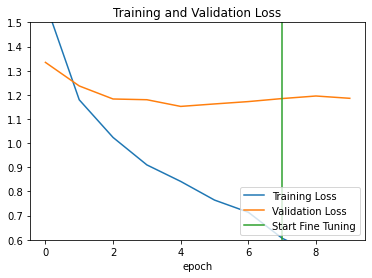

<Figure size 432x288 with 0 Axes>

In [109]:
%matplotlib inline
#print(history.history)

fine_acc= acc[:original_epochs] + history_fine.history['accuracy']
fine_val_acc = val_acc[:original_epochs] + history_fine.history['val_accuracy']
fine_loss = loss[:original_epochs] + history_fine.history['loss']
fine_val_loss= val_loss[:original_epochs] + history_fine.history['val_loss']

epochs=range(len(acc)) # Get number of epochs
print(acc)

plt.plot(fine_acc, label='Training Accuracy')
plt.plot(fine_val_acc, label='Validation Accuracy')
plt.ylim([0.5, 1])
plt.plot([original_epochs,original_epochs],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.figure()


plt.plot(fine_loss, label='Training Loss')
plt.plot(fine_val_loss, label='Validation Loss')
plt.ylim([0.6, 1.5])
plt.plot([original_epochs,original_epochs],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.figure()